# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [117]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [118]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [119]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [120]:
batch[0], batch[0][1].shape

([1,
  array([-0.03413273,  0.18059482, -0.02431473, -0.25157222]),
  1.0,
  False,
  {}],
 (4,))

In [121]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [122]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.345707262690481 -2.9001932807953743


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [123]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    return states, actions, rewards

In [124]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [125]:
def model_loss(states, actions, rewards, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, labels=actions_labels)
    R = tf.reduce_mean(rewards)
    loss = tf.reduce_mean(-log_prob*R)        
    return actions_logits, loss

In [89]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [90]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.rewards = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, rewards=self.rewards) # model input
        
        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [91]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(9, 4) actions:(9,)
1


In [103]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [104]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [105]:
env.reset()

array([-0.01965487, -0.02073975, -0.01959313, -0.03804288])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [106]:
state, reward, action

(array([ 0.06900697,  0.45066273, -0.21001337, -1.06933499]), 1.0, 1)

In [113]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            #reward = 1 - float(done)
            #action *= 1 - float(done) # last action is always 0
            batch.append([state, action, reward])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                 model.actions: actions, 
                                                                 model.rewards: rewards})
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(rewards.sum()) ,
              'Batch loss: {:.9f}'.format(loss))
        rewards_list.append((ep, len(batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

Episode: 0 Total reward: 8.0 Batch loss: -0.625191092
Episode: 1 Total reward: 26.0 Batch loss: -0.672917604
Episode: 2 Total reward: 25.0 Batch loss: -0.676734924
Episode: 3 Total reward: 28.0 Batch loss: -0.677655518
Episode: 4 Total reward: 21.0 Batch loss: -0.680638552
Episode: 5 Total reward: 14.0 Batch loss: -0.680788100
Episode: 6 Total reward: 9.0 Batch loss: -0.678688645
Episode: 7 Total reward: 11.0 Batch loss: -0.683901548
Episode: 8 Total reward: 15.0 Batch loss: -0.683872342
Episode: 9 Total reward: 32.0 Batch loss: -0.683841944
Episode: 10 Total reward: 25.0 Batch loss: -0.685484409
Episode: 11 Total reward: 27.0 Batch loss: -0.684588253
Episode: 12 Total reward: 45.0 Batch loss: -0.686024070
Episode: 13 Total reward: 103.0 Batch loss: -0.684565187
Episode: 14 Total reward: 150.0 Batch loss: -0.684351325
Episode: 15 Total reward: 200.0 Batch loss: -0.681037366
Episode: 16 Total reward: 200.0 Batch loss: -0.683433533
Episode: 17 Total reward: 200.0 Batch loss: -0.686766386

Episode: 151 Total reward: 9.0 Batch loss: -0.688490629
Episode: 152 Total reward: 10.0 Batch loss: -0.689102352
Episode: 153 Total reward: 15.0 Batch loss: -0.690673947
Episode: 154 Total reward: 18.0 Batch loss: -0.691116035
Episode: 155 Total reward: 25.0 Batch loss: -0.691182494
Episode: 156 Total reward: 200.0 Batch loss: -0.691366196
Episode: 157 Total reward: 51.0 Batch loss: -0.691392481
Episode: 158 Total reward: 39.0 Batch loss: -0.689521968
Episode: 159 Total reward: 140.0 Batch loss: -0.690253258
Episode: 160 Total reward: 156.0 Batch loss: -0.691267133
Episode: 161 Total reward: 47.0 Batch loss: -0.690467179
Episode: 162 Total reward: 35.0 Batch loss: -0.690723538
Episode: 163 Total reward: 22.0 Batch loss: -0.691270888
Episode: 164 Total reward: 10.0 Batch loss: -0.690577984
Episode: 165 Total reward: 114.0 Batch loss: -0.690174758
Episode: 166 Total reward: 122.0 Batch loss: -0.689624786
Episode: 167 Total reward: 120.0 Batch loss: -0.689875901
Episode: 168 Total reward:

Episode: 296 Total reward: 60.0 Batch loss: -0.690713286
Episode: 297 Total reward: 30.0 Batch loss: -0.690190315
Episode: 298 Total reward: 20.0 Batch loss: -0.688534737
Episode: 299 Total reward: 14.0 Batch loss: -0.688269079
Episode: 300 Total reward: 19.0 Batch loss: -0.689021289
Episode: 301 Total reward: 15.0 Batch loss: -0.689628065
Episode: 302 Total reward: 13.0 Batch loss: -0.688296616
Episode: 303 Total reward: 8.0 Batch loss: -0.685598850
Episode: 304 Total reward: 10.0 Batch loss: -0.685260653
Episode: 305 Total reward: 11.0 Batch loss: -0.688633084
Episode: 306 Total reward: 10.0 Batch loss: -0.690688312
Episode: 307 Total reward: 12.0 Batch loss: -0.690616786
Episode: 308 Total reward: 43.0 Batch loss: -0.690749347
Episode: 309 Total reward: 24.0 Batch loss: -0.691688836
Episode: 310 Total reward: 10.0 Batch loss: -0.691576719
Episode: 311 Total reward: 11.0 Batch loss: -0.691443980
Episode: 312 Total reward: 13.0 Batch loss: -0.691751361
Episode: 313 Total reward: 49.0 

Episode: 449 Total reward: 48.0 Batch loss: -0.692307174
Episode: 450 Total reward: 113.0 Batch loss: -0.692015648
Episode: 451 Total reward: 87.0 Batch loss: -0.691246212
Episode: 452 Total reward: 83.0 Batch loss: -0.691876173
Episode: 453 Total reward: 47.0 Batch loss: -0.692128718
Episode: 454 Total reward: 19.0 Batch loss: -0.692179322
Episode: 455 Total reward: 15.0 Batch loss: -0.691394031
Episode: 456 Total reward: 12.0 Batch loss: -0.691601574
Episode: 457 Total reward: 9.0 Batch loss: -0.691382289
Episode: 458 Total reward: 11.0 Batch loss: -0.691822231
Episode: 459 Total reward: 18.0 Batch loss: -0.691793203
Episode: 460 Total reward: 27.0 Batch loss: -0.692283630
Episode: 461 Total reward: 42.0 Batch loss: -0.691762030
Episode: 462 Total reward: 30.0 Batch loss: -0.690882921
Episode: 463 Total reward: 16.0 Batch loss: -0.691500247
Episode: 464 Total reward: 12.0 Batch loss: -0.691708803
Episode: 465 Total reward: 12.0 Batch loss: -0.691863239
Episode: 466 Total reward: 38.0

Episode: 599 Total reward: 12.0 Batch loss: -0.690734208
Episode: 600 Total reward: 15.0 Batch loss: -0.690421700
Episode: 601 Total reward: 12.0 Batch loss: -0.690873682
Episode: 602 Total reward: 12.0 Batch loss: -0.691127539
Episode: 603 Total reward: 15.0 Batch loss: -0.691177130
Episode: 604 Total reward: 9.0 Batch loss: -0.690422595
Episode: 605 Total reward: 21.0 Batch loss: -0.691920280
Episode: 606 Total reward: 126.0 Batch loss: -0.692096412
Episode: 607 Total reward: 9.0 Batch loss: -0.689672768
Episode: 608 Total reward: 11.0 Batch loss: -0.689840496
Episode: 609 Total reward: 9.0 Batch loss: -0.690367937
Episode: 610 Total reward: 37.0 Batch loss: -0.691609383
Episode: 611 Total reward: 57.0 Batch loss: -0.691521466
Episode: 612 Total reward: 200.0 Batch loss: -0.691788912
Episode: 613 Total reward: 76.0 Batch loss: -0.691886306
Episode: 614 Total reward: 64.0 Batch loss: -0.691236734
Episode: 615 Total reward: 76.0 Batch loss: -0.689794362
Episode: 616 Total reward: 57.0 

Episode: 743 Total reward: 200.0 Batch loss: -0.692708075
Episode: 744 Total reward: 200.0 Batch loss: -0.692591250
Episode: 745 Total reward: 120.0 Batch loss: -0.692423940
Episode: 746 Total reward: 44.0 Batch loss: -0.690606534
Episode: 747 Total reward: 65.0 Batch loss: -0.691055357
Episode: 748 Total reward: 23.0 Batch loss: -0.691717803
Episode: 749 Total reward: 18.0 Batch loss: -0.689882934
Episode: 750 Total reward: 14.0 Batch loss: -0.690972209
Episode: 751 Total reward: 14.0 Batch loss: -0.690728366
Episode: 752 Total reward: 12.0 Batch loss: -0.691257656
Episode: 753 Total reward: 10.0 Batch loss: -0.690679491
Episode: 754 Total reward: 11.0 Batch loss: -0.690135002
Episode: 755 Total reward: 11.0 Batch loss: -0.689823568
Episode: 756 Total reward: 10.0 Batch loss: -0.690263748
Episode: 757 Total reward: 9.0 Batch loss: -0.691209793
Episode: 758 Total reward: 10.0 Batch loss: -0.692285061
Episode: 759 Total reward: 10.0 Batch loss: -0.687998533
Episode: 760 Total reward: 10

Episode: 887 Total reward: 123.0 Batch loss: -0.692771852
Episode: 888 Total reward: 200.0 Batch loss: -0.692853212
Episode: 889 Total reward: 200.0 Batch loss: -0.692917168
Episode: 890 Total reward: 200.0 Batch loss: -0.692963541
Episode: 891 Total reward: 200.0 Batch loss: -0.692971647
Episode: 892 Total reward: 109.0 Batch loss: -0.692722261
Episode: 893 Total reward: 77.0 Batch loss: -0.692610800
Episode: 894 Total reward: 110.0 Batch loss: -0.692625284
Episode: 895 Total reward: 64.0 Batch loss: -0.692837119
Episode: 896 Total reward: 34.0 Batch loss: -0.692168832
Episode: 897 Total reward: 32.0 Batch loss: -0.691819131
Episode: 898 Total reward: 36.0 Batch loss: -0.691939235
Episode: 899 Total reward: 37.0 Batch loss: -0.691648304
Episode: 900 Total reward: 10.0 Batch loss: -0.692162812
Episode: 901 Total reward: 37.0 Batch loss: -0.691634715
Episode: 902 Total reward: 20.0 Batch loss: -0.692737281
Episode: 903 Total reward: 15.0 Batch loss: -0.692613304
Episode: 904 Total rewar

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

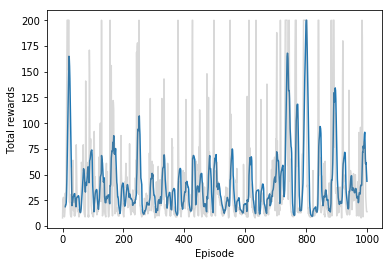

In [115]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Batch losses')

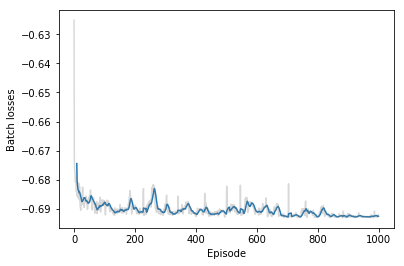

In [116]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch losses')

## Testing

Let's checkout how our trained agent plays the game.

In [29]:
import gym
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-pg.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            if done:
                break
                
        # Closing the env
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-pg.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.